In [55]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd

from scipy.optimize     import minimize, curve_fit
from scipy.stats        import chi2
from math               import pi
from matplotlib.ticker  import MaxNLocator

import scipy
import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

## Task 1

In [72]:
def f(vars):
    """2D six-hump camelback function"""
    x = vars[0]
    y = vars[1]
    return (4-2.1*x**2+x**4/3)*x**2 + x*y + (4*y**2-4)*y**2

xgrid = np.linspace(-2, 2, 500)
ygrid = np.linspace(-1, 1, 500)

X, Y = np.meshgrid(xgrid, ygrid)

# compute the function given the xy grid points
Z = f((X, Y))

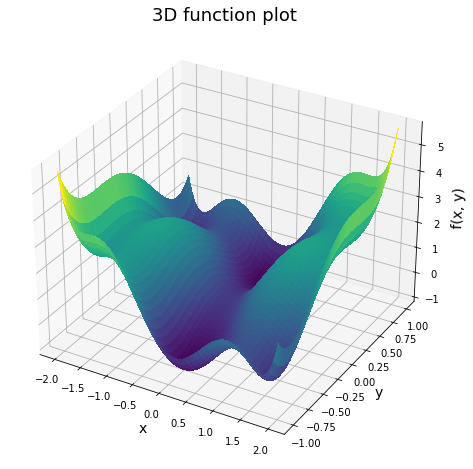

In [75]:
# 3D PLOT

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

im3d = ax.plot_surface(X, Y, Z, cmap="viridis", antialiased=False)

ax.set_title("3D function plot", fontsize=18)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_zlabel("f(x, y)", fontsize=14)

plt.show()

In [114]:
initial_guesses = [
    [0, 0],
    [0, -0.75],
    [0, 0.75],
    [1, 0],
    [-1, 0]
]

# minimization of the function given a set of initial guesses
minima = [minimize(f, x0=guess) for guess in initial_guesses]

for min, guess in zip(minima, initial_guesses):
    x = min.x[0]
    y = min.x[1]
    z = min.fun
    xguess = guess[0]
    yguess = guess[1]

    print(f"Initial guess: ({xguess:.2f}, {yguess:.2f}) \t ----> \t minimum: {z:.2f} at ({x:.2f}, {y:.2f})")


Initial guess: (0.00, 0.00) 	 ----> 	 minimum: 0.00 at (0.00, 0.00)
Initial guess: (0.00, -0.75) 	 ----> 	 minimum: -1.03 at (0.09, -0.71)
Initial guess: (0.00, 0.75) 	 ----> 	 minimum: -1.03 at (-0.09, 0.71)
Initial guess: (1.00, 0.00) 	 ----> 	 minimum: -1.03 at (0.09, -0.71)
Initial guess: (-1.00, 0.00) 	 ----> 	 minimum: -1.03 at (-0.09, 0.71)


In [ ]:
print("There are 2 global minima, and the function evaluated at those points is -1.03")
print("If we choose (0,0) as initial guess the minimization do not converge to neither one of the two minima")

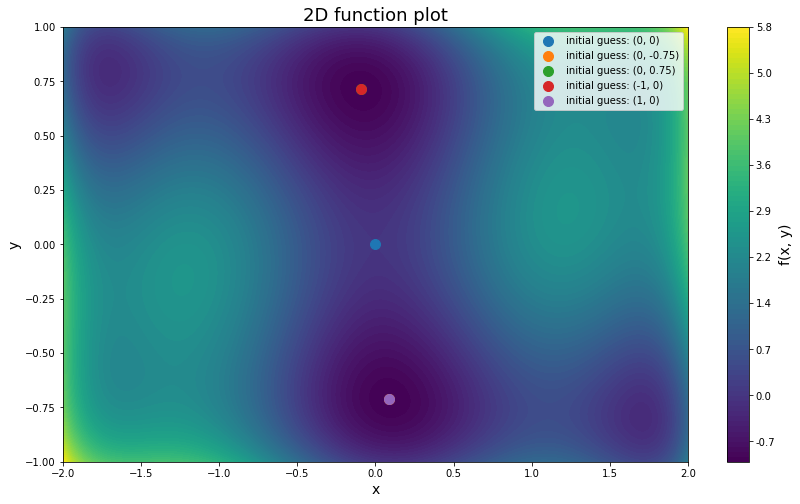

In [105]:
# 2D PLOT WITH MINIMA

fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(111)

im = ax.contourf(X, Y, Z, levels=100, origin="lower")
cbar = plt.colorbar(im, ax=ax)

ax.set_title("2D function plot", fontsize=18)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
cbar.ax.set_ylabel("f(x, y)", fontsize=14)
cbar.ax.set_yticklabels(["{:.1f}".format(i) for i in cbar.get_ticks()])

# plot minima
for min, guess in zip(minima, initial_guesses):
    ax.scatter(min.x[0], min.x[1], s=100, label=f"initial guess: ({guess[0]}, {guess[1]})")

ax.legend()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

## Task 2

In [163]:
t_max = np.array([17,   19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
t_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]) # cold huh

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
num_months = [i for i in range(len(months))]

In [180]:
def f(x, a, b, c, d):
    """gaussian function"""
    return a + b * np.exp(-np.power(x - c, 2.) / (2 * np.power(d, 2.)))

par_list = ["offset", "scale", "mean", "sigma"]


In [199]:
# initial guesses
p0_min = [t_min.min(), t_min.max() - t_min.min(), t_min.argmax(), 2]
p0_max = [t_max.min(), t_max.max() - t_max.min(), t_max.argmax(), 2]

# fitting data
par_max, cov_max = curve_fit(f=f, xdata=num_months, ydata=t_max, p0=p0_max)
par_min, cov_min = curve_fit(f=f, xdata=num_months, ydata=t_min, p0=p0_min)

# computing parameter uncertainties
err_max = np.sqrt(cov_max.diagonal())
err_min = np.sqrt(cov_min.diagonal())

fit_max = list(zip(par_list, par_max, err_max))
fit_min = list(zip(par_list, par_min, err_min))

print("\nMAX TEMPERATURES FIT:")
print()
for n, p, e in fit_max:
    print(f"{n}:\t\t {p:8.3f} +/- {e:6.3f}  \t\t relative error: \t {np.abs(e/p):.2%}")
print()
print("\nMIN TEMPERATURES FIT:")
print()
for n, p, e in fit_min:
    print(f"{n}:\t\t {p:8.3f} +/- {e:6.3f}  \t\t relative error: \t {np.abs(e/p):.2%}")


MAX TEMPERATURES FIT:

offset:		   15.779 +/-  1.177  		 relative error: 	 7.46%
scale:		   23.092 +/-  1.153  		 relative error: 	 4.99%
mean:		    5.736 +/-  0.079  		 relative error: 	 1.39%
sigma:		    2.294 +/-  0.166  		 relative error: 	 7.23%


MIN TEMPERATURES FIT:

offset:		  -61.321 +/-  1.189  		 relative error: 	 1.94%
scale:		   52.649 +/-  1.403  		 relative error: 	 2.67%
mean:		    6.165 +/-  0.047  		 relative error: 	 0.77%
sigma:		    1.976 +/-  0.076  		 relative error: 	 3.85%


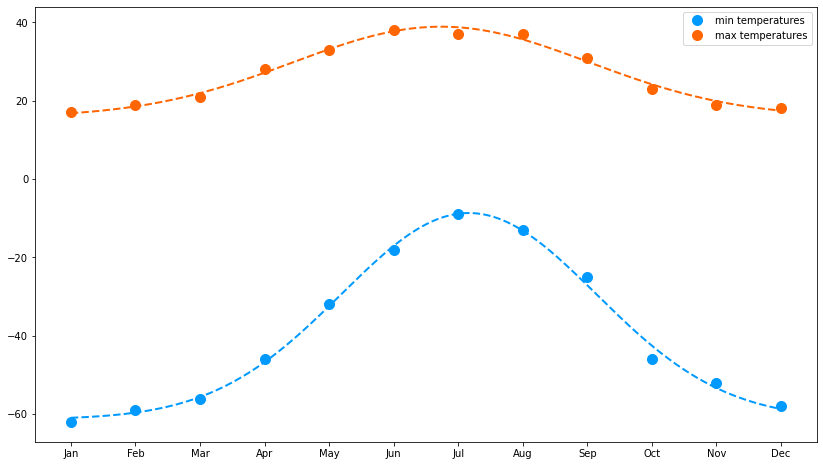

In [166]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(months, t_min, color="#009AFF", lw=3, ls="none", marker="o", markersize=10, label="min temperatures")
ax.plot(months, t_max, color="#ff6500", lw=3, ls="none", marker="o", markersize=10, label="max temperatures")

grid = np.linspace(num_months[0], num_months[-1], 500)
ax.plot(grid, f(grid, *par_min), color="#009AFF", lw=2, ls="dashed")
ax.plot(grid, f(grid, *par_max), color="#ff6500", lw=2, ls="dashed")

ax.legend()
plt.show()

In [206]:
print("The two fit look reasonable. Without knowing uncertainties of the measurements, we cannot be that much quantitative about that though.")
print("However the fitted function approximates the behaviour of datapoints reasonably well!\n\n")

print("To tell whether the time offset (mean of the gaussian) is the same we check for compatibility between the two means.\n")

def comp(a, erra, b, errb):
    """compatibility between two estimates with uncertainties"""
    return np.abs(a-b)/np.sqrt(erra**2+errb**2)

mu_max = fit_max[-2]
mu_min = fit_min[-2]

c = comp(mu_max[1], mu_max[2], mu_min[1], mu_min[2])

print(f"The two time offsets show a compatibility of {c:.2f}, which shows that the two are not the same.")

The two fit look reasonable. Without knowing uncertainties of the measurements, we cannot be that much quantitative about that though.
However the fitted function approximates the behaviour of datapoints reasonably well!


To tell whether the time offset (mean of the gaussian) is the same we check for compatibility between the two means.

The two time offsets show a compatibility of 4.64, which shows that the two are not the same.


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

## Task 3

In [37]:
data_file = "./data/residuals_261.pkl"
data = np.load(data_file, allow_pickle=True)
df = pd.DataFrame(data.item())

# clean dataset
df = df[abs(df["residuals"]) < 2.]

x=df["residuals"]

In [142]:
BINS = 50
hist, edges = np.histogram(x, bins=BINS)

# extract information on the binning
binswidth = edges[1]-edges[0]
bincenters = 0.5 * (edges[1:]+edges[:-1])

# poisson errors
err = np.sqrt(hist)

In [143]:
def f(x, A, mu, sigma):
    """gaussian function"""
    return A * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

par_list = ["scale", "mean", "sigma"]

In [157]:
# initial guesses
p0 = [hist.max(), edges[hist.argmax()], x.std()]

# fitting data
par, cov = curve_fit(f=f, xdata=edges[:-1], ydata=hist, p0=p0, absolute_sigma=True)

# parameter uncertainties
fit_err = np.sqrt(cov.diagonal())

fit = list(zip(par_list, par, fit_err))

xgrid=np.linspace(edges[0], edges[-1], 500)
func = f(edges[:-1], *par)
res = hist - func

# compute chi2 
chisq = np.sum((res/err)**2)
# number of degrees of freedom
ndf=hist.shape[0]-par.shape[0]
# p-value
pval = chi2.sf(chisq, df=ndf)

print("\nMAX TEMPERATURES FIT:")
print()
for n, p, e in fit:
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")

print(f"chi2 / ndf: \t {chisq:.2f} / {ndf} \t---->\t pval = {pval:.3e}")


MAX TEMPERATURES FIT:

scale:		 1286.85236 +/- 0.54635  		 relative error: 	 0.042%
mean:		   -0.12551 +/- 0.00011  		 relative error: 	 0.088%
sigma:		    0.22641 +/- 0.00011  		 relative error: 	 0.049%
chi2 / ndf: 	 1298.67 / 47 	---->	 pval = 3.670e-241


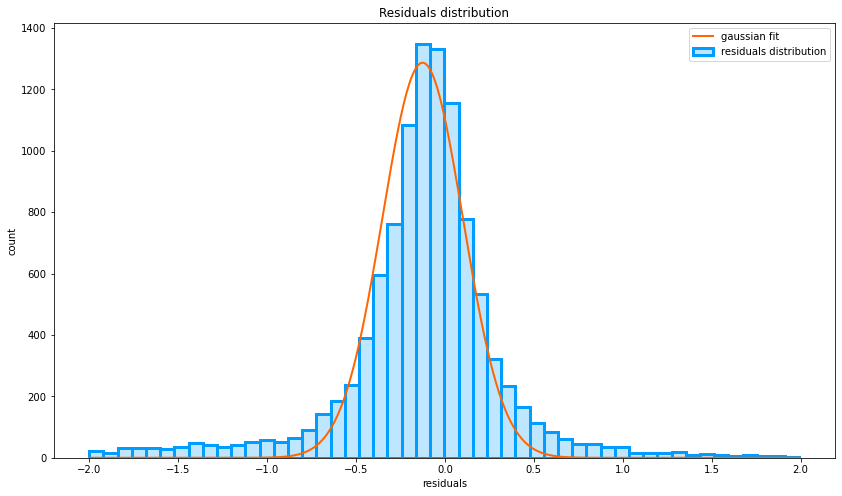

In [145]:
fig, ax = plt.subplots(figsize=(14,8))

# histogram
sns.histplot(
    x=edges[:-1],
    weights=hist,
    bins=edges,
    color="#aadeff",
    edgecolor="#009cff",
    lw=3,
    label="residuals distribution",
    ax=ax
)

ax.plot(xgrid, f(xgrid, *par), lw=2, color="#ff6500", label="gaussian fit")

ax.set_title("Residuals distribution")
ax.set_xlabel("residuals")
ax.set_ylabel("count")

ax.legend()
plt.show()

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

## Task 4

In [47]:
def f(x, a, b, c):
    return a*np.cos(2*pi*x + b) + c

par_list1 = ["a", "b", "c"]

def g(x, a, b, c, d):
    return a*np.cos(2*pi*b*x + c) + d

par_list2 = ["a", "b", "c", "d"]

In [3]:
df = pd.read_csv("./data/munich_temperatures_average_with_bad_data.txt", sep=" ", header=None, names=["year", "temperature"])

In [48]:
par1, cov1 = curve_fit(f=f, xdata=df.year, ydata=df.temperature)
par2, cov2 = curve_fit(f=g, xdata=df.year, ydata=df.temperature)

# parameter uncertainties
fit_err1 = np.sqrt(cov1.diagonal())
fit_err2 = np.sqrt(cov2.diagonal())

print("\nFIRST MODEL:\n")
for n, p, e in zip(par_list1, par1, fit_err1):
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")
print()
print("\nSECOND MODEL:\n")
for n, p, e in zip(par_list2, par2, fit_err2):
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")


FIRST MODEL:

a:		   -9.88877 +/- 0.13631  		 relative error: 	 1.378%
b:		   12.30923 +/- 0.01385  		 relative error: 	 0.113%
c:		    8.60030 +/- 0.09663  		 relative error: 	 1.124%


SECOND MODEL:

a:		   -9.88899 +/- 0.13641  		 relative error: 	 1.379%
b:		    1.00016 +/- 0.00042  		 relative error: 	 0.042%
c:		   10.23469 +/- 5.25632  		 relative error: 	 51.358%
d:		    8.60105 +/- 0.09665  		 relative error: 	 1.124%


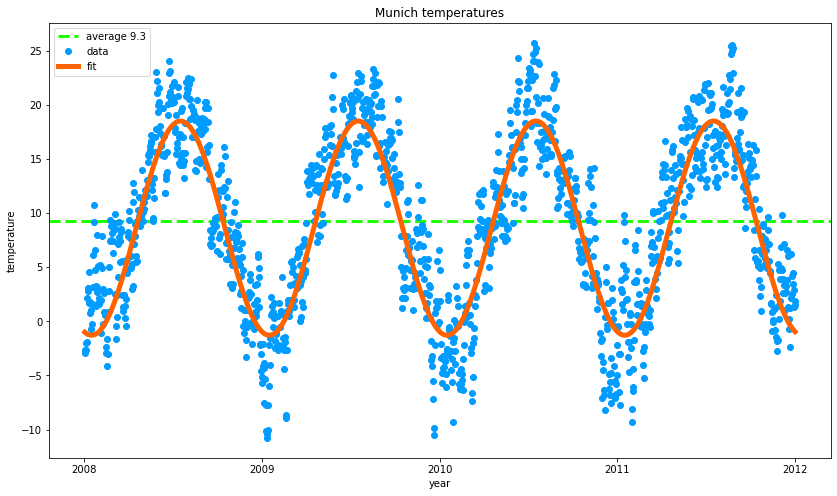

In [30]:
mask = (df.year>2008) & (df.year<2012)
df=df[df.temperature<60] # removing outliers, temperatures above 60 degrees are 100% not reliable... and 60 is a high threshold!

x=df[mask]["year"]
y=df[mask]["temperature"]

avg_temp = y.mean()

fig, ax = plt.subplots(figsize=(14, 8))
ax.axhline(y=avg_temp,  lw=3,   ls="--",                color="#1dff00", label=f"average {avg_temp:.1f}")
ax.plot(x, y,                   ls="none", marker="o",  color="#009cff", label="data")
ax.plot(x, f(x, *par1), lw=5,   ls="-",                 color="#ff6300", label="fit")
# ax.plot(x, g(x, *par2), lw=3)

ax.set_title("Munich temperatures")
ax.set_xlabel("year")
ax.set_ylabel("temperature")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend()
plt.show()

In [40]:
print(f"The overall average is given my the mean of the temperatures: {avg_temp:.1f}")
print()
print("The typical daily average values predicted by the model for the coldest and hottest time of year are given by the minimum and maximum values of the cosine:")
print(f"Daily average for the coldest time of the year: {f(x, *par1).min():.1f}")
print(f"Daily average for the hottest time of the year: {f(x, *par1).max():.1f}")
print("\n\n")
print("The b parameter is shifting the cosine along the x axis and allows for more flexibility. Without the b parameter we would need to shift data to have one of its maxima at 0 in order to perform a fit.")
print("'Physically' it is a phase parameter that determine the initial phase of the cosine (not very physical though..)")

The overall average is given my the mean of the temperatures: 9.3

The typical daily average values predicted by the model for the coldest and hottest time of year are given by the minimum and maximum values of the cosine:
Daily average for the coldest time of the year: -1.3
Daily average for the hottest time of the year: 18.5



The b parameter is shifting the cosine along the x axis and allows for more flexibility. Without the b parameter we would need to shift data to have one of its maxima at 0 in order to perform a fit.
'Physically' it is a phase parameter that determine the initial phase of the cosine (not very physical though..)


In [58]:
def FTest(ssr1, ssr2, ndf1, ndf2, n):
    """Fisher F-Test"""
    F = ((ssr1 - ssr2)/(ndf2 - ndf1)) / (ssr2/(n - ndf2))
    CL = 1. - scipy.stats.f.cdf(F, ndf2 - ndf1, n - ndf2)
    print(f"CL: {CL:.3f}, additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

In [57]:
# assuming that RSS is what we called SSR during class i.e. the sum of squared residuals
ssr1 = np.sum((df.temperature - f(df.year, *par1))**2)
ssr2 = np.sum((df.temperature - g(df.year, *par2))**2)

ndf1 = len(par1) - 1 # n of parameters - 1
ndf2 = len(par2) - 1 # n of parameters - 1

CL = FTest(ssr1, ssr2, ndf1, ndf2, y.count())

CL: 0.853, additional parameter necessary: NO
